Converged after 270 iterations

Final policy for initial state:
State: (((0, 1), -1), ((1, 2), -1), ((2, 3), -1), ((3, 4), -1))
Action: ()


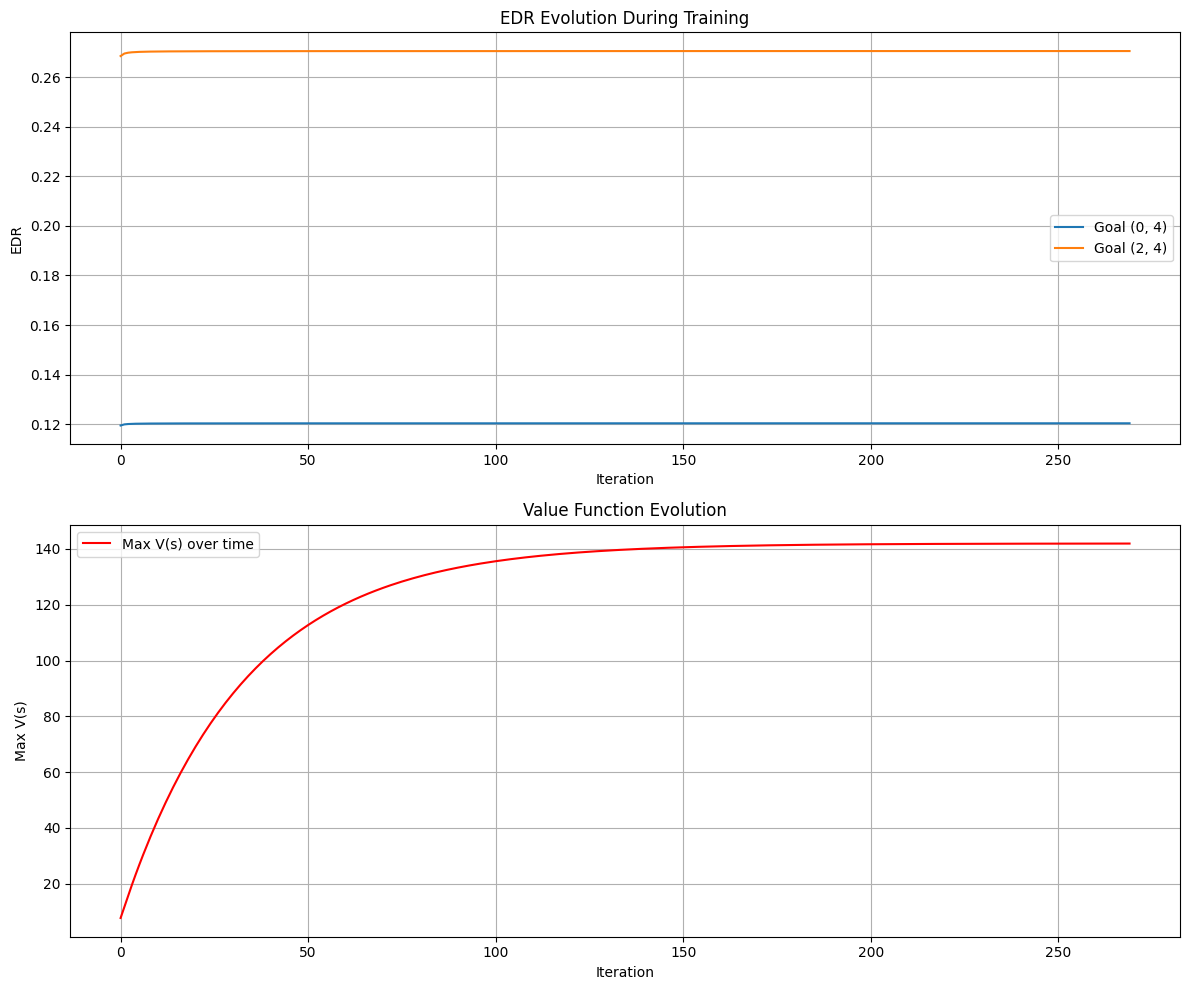

    EDR for goal (0, 4): 0.0000
    EDR for goal (2, 4): 0.0000
    EDR for goal (0, 4): 0.0000
    EDR for goal (2, 4): 0.3333
    EDR for goal (0, 4): 0.0000
    EDR for goal (2, 4): 0.2500
    EDR for goal (0, 4): 0.0000
    EDR for goal (2, 4): 0.4000
    EDR for goal (0, 4): 0.0000
    EDR for goal (2, 4): 0.3333
    EDR for goal (0, 4): 0.1429
    EDR for goal (2, 4): 0.2857
    EDR for goal (0, 4): 0.2500
    EDR for goal (2, 4): 0.2500
    EDR for goal (0, 4): 0.2222
    EDR for goal (2, 4): 0.2222
    EDR for goal (0, 4): 0.2000
    EDR for goal (2, 4): 0.3000
    EDR for goal (0, 4): 0.1818
    EDR for goal (2, 4): 0.2727
    EDR for goal (0, 4): 0.2500
    EDR for goal (2, 4): 0.2500
    EDR for goal (0, 4): 0.2308
    EDR for goal (2, 4): 0.3077
    EDR for goal (0, 4): 0.2857
    EDR for goal (2, 4): 0.2857
    EDR for goal (0, 4): 0.2667
    EDR for goal (2, 4): 0.2667
    EDR for goal (0, 4): 0.3125
    EDR for goal (2, 4): 0.2500
    EDR for goal (0, 4): 0.2941
    EDR 

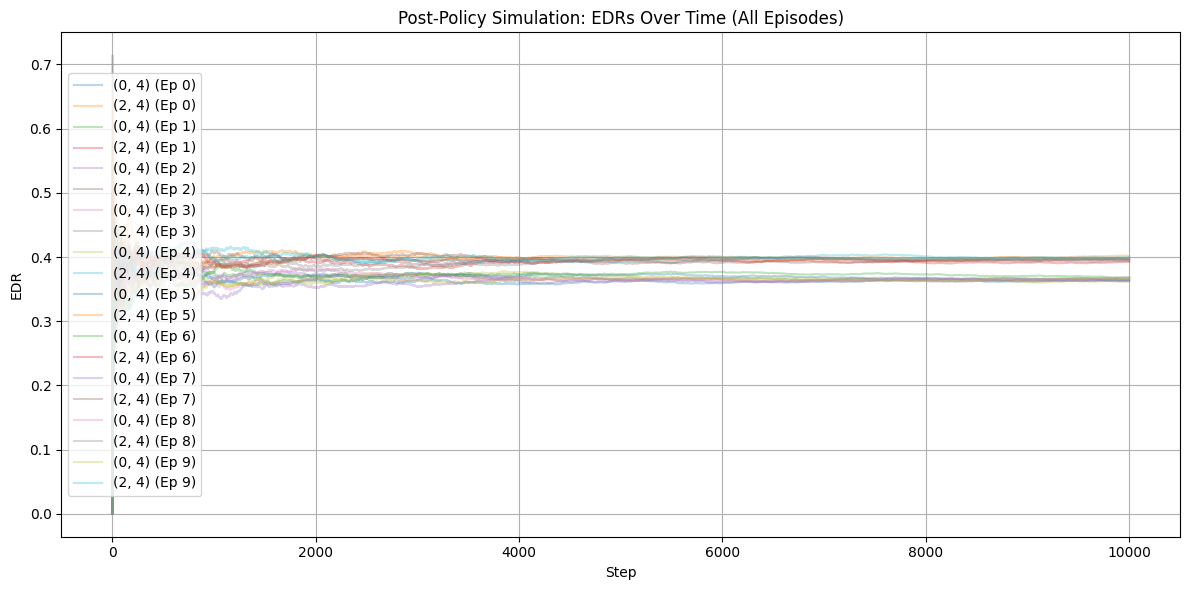


[DEBUG] Q-values for fully entangled state:
  Action: () => Q-value: 139.0968
  Action: ((0, 4),) => Q-value: 140.4194
  Action: ((2, 4),) => Q-value: 141.1107


In [85]:
# Q-VALUE ITERATION WITH EXPLICIT ACTIONS FOR QUANTUM NETWORK ENTANGLEMENT

from collections import defaultdict
from itertools import product, combinations
import random
import numpy as np
import matplotlib.pyplot as plt

# === CONFIGURATION ===
edges = [(0, 1), (1,2), (2, 3), (3, 4)]
goalEdges = [(0, 4), (2, 4)]
pSwap = 1
pGen = 0.8
maxAge = 2
gamma = 0.99
epsilon = 0.001
max_iterations = 1000
temp = 1.0  # Temperature for softmax

# === STATE GENERATION ===
def getPossibleStates(edges, max_age):
    sorted_edges = sorted(tuple(sorted(e)) for e in edges)
    possible_ages = [-1] + list(range(1, max_age + 1))
    return [
        tuple(zip(sorted_edges, age_combo))
        for age_combo in product(possible_ages, repeat=len(sorted_edges))
    ]

# === STATE UPDATE HELPERS ===
def age_entanglements(state, maxAge):
    new_state = []
    for edge, age in state:
        if age == -1:
            new_state.append((edge, -1))
        else:
            new_age = age + 1
            new_state.append((edge, new_age if new_age <= maxAge else -1))
    return tuple(sorted(new_state))

def generate_entanglements(state, pGen):
    new_state = []
    for edge, age in state:
        if age == -1 and random.random() < pGen:
            new_state.append((edge, 1))
        else:
            new_state.append((edge, age))
    return tuple(sorted(new_state))

# === REWARD FUNCTION WITH LAPLACE SMOOTHING ===
def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
    if achieved_goals is None:
        return 0
    reward = 0
    for goal, success in achieved_goals:
        if success:
            hops = abs(goal[1] - goal[0])
            rate = pSwap ** (hops - 1)
            smoothed_edr = (goal_success_counts[goal] + 1) / (total_timesteps + 5)
            reward += np.log(rate / smoothed_edr + 1e-5)
    return reward

# === TRANSITION MODEL (RESTORED & FIXED FAILURE HANDLING) ===
def generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge):
    transitions = {}
    all_states = getPossibleStates(edges, maxAge)
    for state in all_states:
        transitions[state] = defaultdict(list)

        # No-op action
        aged_state = age_entanglements(state, maxAge)
        final_state = generate_entanglements(aged_state, pGen)
        transitions[state][()].append((final_state, 1.0, None))

        # Attempt each goal individually
        for goal in goalEdges:
            path = get_path(goal, state)
            if path is None:
                continue
            used_edges = set(path)
            success_prob = pSwap ** (len(path) - 1)
            fail_prob = 1 - success_prob

            # On success: clear used edges
            cleared_state = tuple((e, -1) if e in used_edges else (e, a) for e, a in state)
            aged = age_entanglements(cleared_state, maxAge)
            final = generate_entanglements(aged, pGen)
            transitions[state][(goal,)].append((final, success_prob, [(goal, True)]))

            # On failure: also clear used edges
            cleared_on_fail = tuple((e, -1) if e in used_edges else (e, a) for e, a in state)
            aged_fail = age_entanglements(cleared_on_fail, maxAge)
            final_fail = generate_entanglements(aged_fail, pGen)
            transitions[state][(goal,)].append((final_fail, fail_prob, [(goal, False)]))

    return transitions

def get_path(goal, state):
    graph = defaultdict(list)
    for (e1, e2), age in state:
        if age > 0:
            graph[e1].append(e2)
            graph[e2].append(e1)
    start, end = goal
    visited = set()
    queue = [(start, [])]
    while queue:
        current, path = queue.pop(0)
        if current == end:
            return path
        if current in visited:
            continue
        visited.add(current)
        for neighbor in graph[current]:
            if neighbor not in visited:
                queue.append((neighbor, path + [tuple(sorted((current, neighbor)))]))
    return None

# === DEBUG Q-VALUES FOR FULLY ENTANGLED STATE ===
def print_q_values_for_fully_entangled_state(Q, edges, maxAge):
    state = tuple((tuple(sorted(edge)), maxAge) for edge in edges)
    print("\n[DEBUG] Q-values for fully entangled state:")
    if state in Q:
        for action, value in Q[state].items():
            print(f"  Action: {action} => Q-value: {value:.4f}")
    else:
        print("  State not found in Q-table.")

# === SIMULATE POLICY WITH SOFTMAX ACTION SELECTION ===
def simulate_policy(policy, all_transitions, goalEdges, initial_state, episodes=10, steps=10000):
    all_episode_edr_histories = []

    for ep in range(episodes):
        goal_success_counts = {goal: 0 for goal in goalEdges}
        total_timesteps = 1
        edr_history = {goal: [] for goal in goalEdges}

        state = initial_state
        for step in range(steps):
            if state not in all_transitions:
                break

            action_rewards = {}
            for action, transitions in all_transitions[state].items():
                expected_reward = 0
                for next_state, prob, achieved_goals in transitions:
                    reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
                    expected_reward += prob * reward
                action_rewards[action] = expected_reward

            if not action_rewards:
                break

            actions, rewards = zip(*action_rewards.items())
            exp_rewards = np.exp(np.array(rewards) / temp)
            probs = exp_rewards / np.sum(exp_rewards)
            best_action = random.choices(actions, weights=probs, k=1)[0]

            transition = random.choices(
                all_transitions[state][best_action],
                weights=[t[1] for t in all_transitions[state][best_action]]
            )[0]

            next_state, prob, achieved_goals = transition
            reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)

            #print(f"[DEBUG] Episode {ep}, Step {step}:")
            #print(f"  State: {state}\n  Action: {best_action}\n  Next State: {next_state}\n  Achieved Goals: {achieved_goals}\n  Reward: {reward:.4f}")

            for goal, success in (achieved_goals or []):
                if success:
                    goal_success_counts[goal] += 1

            total_timesteps += 1
            for goal in goalEdges:
                edr = goal_success_counts[goal] / total_timesteps
                edr_history[goal].append(edr)
                print(f"    EDR for goal {goal}: {edr:.4f}")

            state = age_entanglements(next_state, maxAge)
            state = generate_entanglements(state, pGen)

        all_episode_edr_histories.append(edr_history)

    print("[DEBUG] Completed all episodes.")
    return all_episode_edr_histories

# === RUN MAIN PROCEDURE ===
Q, policy, V, edr_history, value_history, all_transitions = run_q_value_iteration(edges, goalEdges, pSwap, pGen, maxAge)
initial_state = tuple((edge, -1) for edge in edges)

print("\nFinal policy for initial state:")
print(f"State: {initial_state}\nAction: {policy.get(initial_state)}")

# === PLOTS: Training Phase ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
for goal, edrs in edr_history.items():
    ax1.plot(edrs, label=f"Goal {goal}")
ax1.set_title("EDR Evolution During Training")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("EDR")
ax1.grid(True)
ax1.legend()

ax2.plot(value_history, 'r-', label='Max V(s) over time')
ax2.set_title("Value Function Evolution")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Max V(s)")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# === POST-POLICY SIMULATION ===
sim_edr_histories = simulate_policy(policy, all_transitions, goalEdges, initial_state)
plt.figure(figsize=(12, 6))
for ep_num, ep_edrs in enumerate(sim_edr_histories):
    for goal, edrs in ep_edrs.items():
        plt.plot(edrs, alpha=0.3, label=f"{goal} (Ep {ep_num})")
plt.title("Post-Policy Simulation: EDRs Over Time (All Episodes)")
plt.xlabel("Step")
plt.ylabel("EDR")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === DEBUG PRINT ===
print_q_values_for_fully_entangled_state(Q, edges, maxAge)